In [1]:
import numpy as np
from matplotlib import pyplot as plt, cm, colors, colorbar
%matplotlib inline

In [2]:
sample = 'Ts3'
# import tsl grain data
grains = np.genfromtxt('EBSD/Ts3_after_def_ids.txt')
print(len(grains))
grain_fakeids = range(1, len(grains) + 1)  # avoid large ids from TSL

400


In [3]:
from pymicro.crystal.lattice import Symmetry, Lattice, HklPlane
Ti7Al = Lattice.hexagonal(0.2931, 0.4694)  # nm
(a, b, c) = Ti7Al._lengths
(alpha, beta, gamma) = Ti7Al._angles
print(a, b, c)
print(alpha, beta, gamma)
print(Ti7Al._symmetry)

(0.2931, 0.2931, 0.4694)
(90.0, 90.0, 119.99999999999999)
Symmetry.hexagonal


In [4]:
from pymicro.crystal.microstructure import Microstructure, Grain, Orientation

micro_test = Microstructure()
for i in range(len(grains)):
    #print(grains[i, 1:4])
    o_tsl = Orientation.from_euler(grains[i, 1:4])
    o_fz = o_tsl.move_to_FZ(symmetry=Ti7Al._symmetry)
    g = Grain(grains[i, 0], o_tsl)
    g.position = np.array([grains[i, 4], grains[i, 5], 0.])
    micro_test.grains.append(g)

In [5]:
int(255 * max(min((0.5 - 10.0) / float(1000. - 10.), 1.0), 0.0))
print([g.id for g in micro_test.grains].index(30))
print(micro_test.grains.index(micro_test.grains[29]))

29
29


(0, 0, 1)


/usr/lib64/python2.7/site-packages/matplotlib/collections.py:526: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


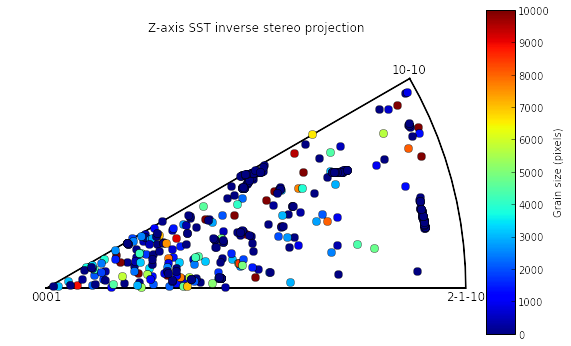

In [6]:
from pymicro.crystal.texture import PoleFigure
from pymicro.crystal.lattice import Lattice

# build a custom pole figure showing the grain size
pf = PoleFigure(microstructure=micro_test, hkl='0001', lattice=Ti7Al)
pf.mksize = 8
pf.set_map_field('size', grains[:, 9], field_min_level=0.0, field_max_level=10000., lut='jet')
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_axes([0.05, 0.05, 0.8, 0.9], aspect='equal')
pf.plot_sst(ax=ax1, mk='o')
# to add the color bar
ax2 = fig.add_axes([0.85, 0.05, 0.05, 0.9])
norm = colors.Normalize(vmin=0., vmax=10000.)
cb = colorbar.ColorbarBase(ax2, cmap=cm.jet, norm=norm, orientation='vertical')
cb.set_label('Grain size (pixels)')
plt.show()

(0, 0, 1)


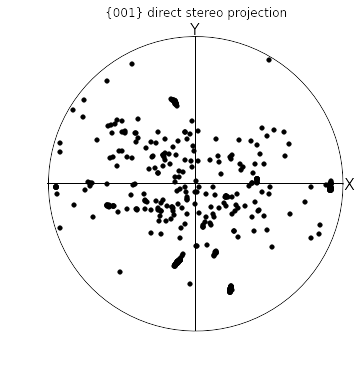

In [7]:
pf = PoleFigure(microstructure=micro_test, lattice=Ti7Al, hkl='001')
pf.mksize = 5
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_axes([0.05, 0.05, 0.8, 0.9], aspect='equal')
pf.plot_pf(ax=ax1, mk='o')
plt.show()

(401, 201)
3.0


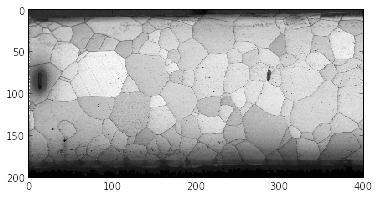

In [8]:
# read the merged ebsd scan data
import h5py
f = h5py.File('EBSD/Ts3_after_def.h5')
nrows = f['Ts3_after_def/EBSD/Header/nRows'][0]
ncols = f['Ts3_after_def/EBSD/Header/nColumns'][0]
scan_step = f['Ts3_after_def/EBSD/Header/Step X'][0]
iq = np.reshape(f['Ts3_after_def/EBSD/Data/IQ'], (nrows, ncols)).T  # [x, y] form with x being the horizontal coordinate
f.close()
print(iq.shape)
print(scan_step)

plt.imshow(iq.T, origin='upper', interpolation='nearest', cmap=cm.gray)

77
(253.219, 234.625)
[106.414  51.363 350.93 ]


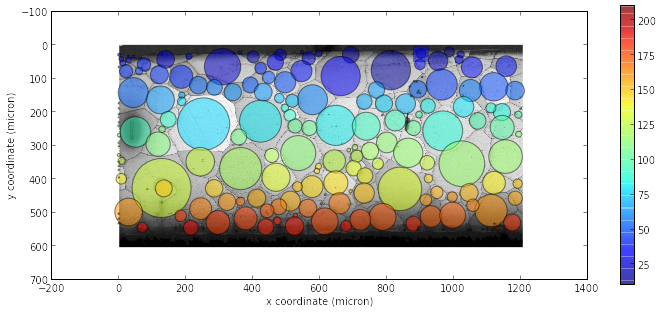

In [9]:
plt.figure(figsize=(12, 5))
N = 10
#N=120
plt.imshow(iq.T, origin='upper', interpolation='nearest', cmap=cm.gray,
           extent=(0, scan_step * iq.shape[0], scan_step * iq.shape[1], 0))
#plt.scatter(grains[:, 4], grains[:, 5], s=0.1*grains[:, 9], c=grain_fakeids[:], alpha=0.5)
plt.scatter(grains[N-1:N+200, 4], grains[N-1:N+200, 5], s=0.1*grains[N-1:N+200, 9], c=grain_fakeids[N-1:N+200], alpha=0.5)
plt.plot(grains[N-1, 4], grains[N-1, 5], 's', markersize=15, alpha=0.5)
plt.colorbar()
plt.xlabel('x coordinate (micron)')
plt.ylabel('y coordinate (micron)')
# look at grain number 77
print(grain_fakeids[76])
print(grains[76, 4], grains[76, 5])
print(grains[76, 1:4])

In [10]:
# transformation matrix from A1A2A3 (EBSD) to XYZ (DCT)
T = np.array([[ 0., 0., -1.],
              [-1., 0.,  0.],
              [ 0., 1.,  0.]])

from pymicro.crystal.microstructure import Microstructure, Grain, Orientation

micro = Microstructure()
for i in range(len(grains)):
    #print(grains[i, 1:4])
    o_tsl = Orientation.from_euler(grains[i, 1:4])
    g_xyz = np.dot(o_tsl.orientation_matrix(), T.T)  # move to XYZ local frame
    o_xyz = Orientation(g_xyz).move_to_FZ(symmetry=Ti7Al._symmetry)
    g = Grain(grain_fakeids[i], o_xyz)
    g.position = np.array([grains[i, 4], grains[i, 5], 0.])
    micro.grains.append(g)

In [11]:
print(micro.grains[76])
# R vector from DCT is [0.6317, -0.4553, -0.0236]

Grain
 * id = 77
 * Crystal Orientation
orientation matrix = [[ 0.72957739 -0.45847425  0.50746251]
 [-0.27903631  0.47788746  0.83292395]
 [-0.62438415 -0.74928295  0.22072492]]
Euler angles (degrees) = ( 320.195,  77.248,  31.352)
Rodrigues vector = [ 0.65159936 -0.46612776 -0.07389782]
 * position [253.219 234.625   0.   ]
 * has vtk mesh ? False



Plot slip traces on the surface
--

Crystal Orientation
orientation matrix = [[-0.18462556  0.97506456 -0.12313616]
 [-0.63599407 -0.02301345  0.77135071]
 [ 0.74928295  0.22072492  0.62438415]]
Euler angles (degrees) = ( 106.414,  51.363, 350.930)
Rodrigues vector = [0.3886555  0.61579114 1.13715486]
Crystal Orientation
orientation matrix = [[ 0.76063943 -0.55148438 -0.34248013]
 [ 0.61682388  0.77843832  0.11645636]
 [ 0.20237579 -0.29983122  0.93227961]]
Euler angles (degrees) = (  34.018,  21.207, 288.780)
Rodrigues vector = [ 0.11992069  0.1569576  -0.33655661]


[0, 1200, 600, 0]

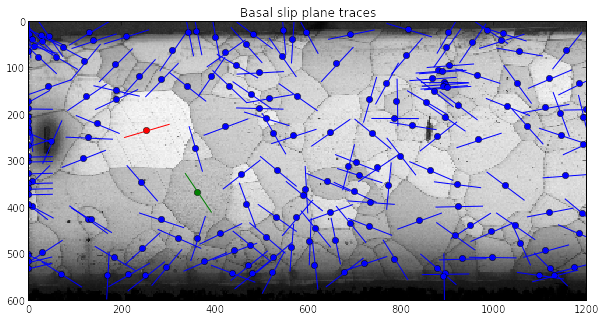

In [13]:
from pymicro.crystal.lattice import Lattice, HklPlane, HklDirection

trace_size = 100  # micron
Ti7Al = Lattice.hexagonal(0.2931, 0.4694)  # nm
p_basal = HklPlane(0, 0, 1, Ti7Al)  # basal plane
n_int = np.array([1, 0, 0])  # since X is going through the sample
view_up = np.array([0, 1, 0])  # here we want a figure with the sample horizontal as in the EBSD

#n_int = np.array([0, 0, -1])  # for orientation data in A1A2A3 (TSL)
#view_up = np.array([1, 0, 0])  # for orientation data in A1A2A3 (TSL)

plt.figure(figsize=(12, 5))
plt.imshow(iq.T, origin='upper', interpolation='nearest', cmap=cm.gray,
           extent=(0, scan_step * iq.shape[0], scan_step * iq.shape[1], 0))

for g in micro.grains:
    trace = p_basal.slip_trace(g.orientation, n_int, view_up, trace_size=100, verbose=False)
    if g.id == 77:
        color = 'r'
        print(g.orientation)
    elif g.id == 120:
        color = 'g'
        print(g.orientation)
    else:
        color = 'b'
    if g.id < 10 or g.id > 200:  # avoid spurious grains on the sides
        continue
    x = g.position[0] + np.array([-trace[0] / 2, trace[0] / 2])
    y = g.position[1] + np.array([-trace[1] / 2, trace[1] / 2])
    plt.plot(g.position[0], g.position[1], 'o', color=color)
    plt.plot(x, y, '-', linewidth=1, color=color)
plt.title('Basal slip plane traces')
plt.axis([0, 1200, 600, 0])

In [18]:
from pymicro.crystal.lattice import SlipSystem

'''
PrismaticA
  U   V   T   W | H   K   I   L
  2  -1  -1   0   0   1  -1   0
  1   1  -2   0  -1   1   0   0
  1  -2   1   0  -1   0   1   0
'''


(h, k, l) = HklPlane.four_to_three_indices(0, -1, 1, 0)
(u, v, w) = HklDirection.four_to_three_indices(2, -1, -1, 0)
ss_prism1 = SlipSystem(HklPlane(h, k, l, Ti7Al), HklDirection(u, v, w, Ti7Al))

(h, k, l) = HklPlane.four_to_three_indices(-1, 1, 0, 0)
(u, v, w) = HklDirection.four_to_three_indices(1, 1, -2, 0)
ss_prism2 = SlipSystem(HklPlane(h, k, l, Ti7Al), HklDirection(u, v, w, Ti7Al))

(h, k, l) = HklPlane.four_to_three_indices(-1, 0, 1, 0)
(u, v, w) = HklDirection.four_to_three_indices(1, -2, 1, 0)
ss_prism3 = SlipSystem(HklPlane(h, k, l, Ti7Al), HklDirection(u, v, w, Ti7Al))

ss_prism = [ss_prism1, ss_prism2, ss_prism3]
print(ss_prism1)
print(ss_prism2)
print(ss_prism3)

(0-10)[100]
(-110)[110]
(-100)[010]


Crystal Orientation
orientation matrix = [[ 0.72957739 -0.45847425  0.50746251]
 [-0.27903631  0.47788746  0.83292395]
 [-0.62438415 -0.74928295  0.22072492]]
Euler angles (degrees) = ( 320.195,  77.248,  31.352)
Rodrigues vector = [ 0.65159936 -0.46612776 -0.07389782]
(0-10)[100]
0.4226776773465311
(-110)[110]
0.022439594695859016
(-100)[010]
0.400238082650672
Crystal Orientation
orientation matrix = [[ 0.27209423  0.15386544 -0.94988955]
 [-0.23836831  0.96714501  0.08838033]
 [ 0.93227961  0.20237579  0.29983122]]
Euler angles (degrees) = ( 102.248,  72.553, 275.316)
Rodrigues vector = [-0.04489653  0.74128276  0.15447927]
(0-10)[100]
0.08395155049455771
(-110)[110]
0.3453450252272141
(-100)[010]
0.42929657572177166


[0, 1200, 600, 0]

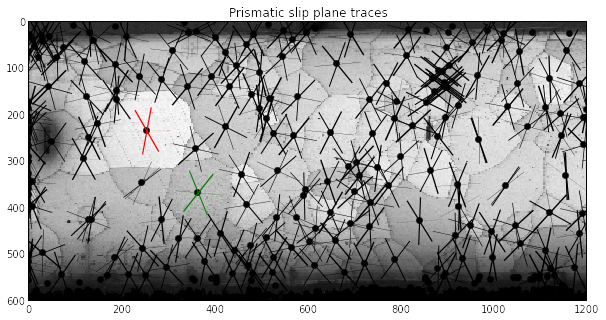

In [19]:
# now try with prismatic planes
import math
import fractions

p_prism1 = HklPlane(0, 1, 0, lattice=Ti7Al)
p_prism2 = HklPlane(-1, 1, 0, lattice=Ti7Al)
p_prism3 = HklPlane(-1, 0, 0, lattice=Ti7Al)
slip_prism = [p_prism1, p_prism2, p_prism3]

n_int = np.array([1, 0, 0])
view_up = np.array([0, 1, 0])

plt.figure(figsize=(12, 5))
plt.imshow(iq.T, origin='upper', interpolation='nearest', cmap=cm.gray,
           extent=(0, scan_step * iq.shape[0], scan_step * iq.shape[1], 0))

for g in micro.grains:
    plt.plot(g.position[0], g.position[1], 'ko')
    if g.id == 77:
        color = 'r'
        print(g.orientation)
        for ss in ss_prism:
            print(ss)
            print(g.orientation.schmid_factor(ss, load_direction=[0., 0., 1]))
    elif g.id == 120:
        color = 'g'
        print(g.orientation)
        for ss in ss_prism:
            print(ss)
            print(g.orientation.schmid_factor(ss, load_direction=[0., 0., 1]))
    else:
        color = 'k'
    if g.id < 10 or g.id > 200:  # avoid spurious grains on the sides
        continue

    for ss in ss_prism:
        p = ss.get_slip_plane()
        lw = 3 * g.orientation.schmid_factor(ss, load_direction=[0., 0., 1])
        trace = p.slip_trace(g.orientation, n_int, view_up, trace_size=100, verbose=False)
        x = g.position[0] + np.array([-trace[0] / 2, trace[0] / 2])
        y = g.position[1] + np.array([-trace[1] / 2, trace[1] / 2])
        plt.plot(x, y, '-', linewidth=lw, color=color)
plt.title('Prismatic slip plane traces')
plt.axis([0, 1200, 600, 0])

In [31]:
lambda_keV = 38
g = micro.grains[76]
(h, k, l) = HklPlane.four_to_three_indices(1, 1, -2, 0)
print(h, k, l)
hkl_dif = HklPlane(h, k, l, Ti7Al)
theta = hkl_dif.bragg_angle(lambda_keV)

print('grain orientation (rodrigues): %s' % str(g.orientation.rod))
gt = g.orientation_matrix().transpose()
Gs = np.dot(gt, hkl_dif.scattering_vector())
print('scattering vector: %s with norm %.3f' % (str(Gs), np.linalg.norm(Gs)))
(h, k, l) = hkl_dif.miller_indices()
print('%d%d%d lattice spacing is %.3f nm' % (h, k, l, 1 / hkl_dif.interplanar_spacing()))


(1, 1, 0)
grain orientation (rodrigues): [ 0.65159936 -0.46612776 -0.07389782]
scattering vector: [0.8402331  1.25981274 6.65345996] with norm 6.824
110 lattice spacing is 6.824 nm


In [32]:
# verify topotomo alignment
(ut, lt) = g.orientation.topotomo_tilts(hkl_dif, verbose=True)
from math import cos, sin, pi
U = np.array([[cos(ut), 0, sin(ut)], [0, 1, 0], [-sin(ut), 0, cos(ut)]])
L = np.array([[1, 0, 0], [0, cos(lt), -sin(lt)], [0, sin(lt), cos(lt)]])
S = np.dot(L, U)
print('tilt matrix T:')
print(S)
T = np.array([[cos(-theta), 0, sin(-theta)], [0, 1, 0], [-sin(-theta), 0, cos(-theta)]])  # base tilt
Gt = np.dot(S, Gs)
Gl = np.dot(T, Gt)
print('scattering vector tilted by samrx and samry: Gt = %s with norm %.3f' % (Gt, np.linalg.norm(Gt)))
print('scattering vector further tilted bt base tilt Gl = %s' % Gl)

up tilt (samry) should be -7.198
low tilt (samrx) should be 10.639
tilt matrix T:
[[ 0.99212016  0.         -0.12529003]
 [-0.02313174  0.98280894 -0.18317074]
 [ 0.12313616  0.18462556  0.97506456]]
scattering vector tilted by samrx and samry: Gt = [-1.11022302e-16  0.00000000e+00  6.82360969e+00] with norm 6.824
scattering vector further tilted bt base tilt Gl = [-0.75956754  0.          6.78120243]


* plane (0-10)
slip plane normal in sample frame: ns = [ 0.27903631 -0.47788746 -0.83292395] with norm 1.000
slip plane normal tilted by samrx and samry: nt = [ 0.38119462 -0.32355937 -0.8660254 ] with norm 1.000
A=0.379, B=0.322, C=0.096, Delta=1.0
the two omega values in degrees fulfilling the Edge-on configuration are (321.5, 119.1)


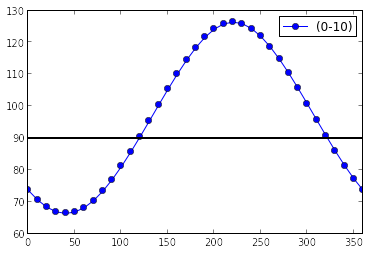

In [33]:
# compute edge-on configuration, diffraction vector is [cos(2theta), 0, sin(2theta)]
p_active = ss_prism1.get_slip_plane()
plt.figure()
Ku = np.array([cos(theta), 0, sin(theta)])
Xu = np.array([1, 0, 0])
omegas = np.linspace(0, 360, 37)
omegas_edge_on = []
for plane in [p_active]:
    (h, k, l) = plane.miller_indices()
    print('* plane (%d%d%d)' % (h, k, l))
    ns = np.dot(gt, plane.normal())  # slip plane normal in sample local frame
    print('slip plane normal in sample frame: ns = %s with norm %.3f' % (ns, np.linalg.norm(ns)))
    nt = np.dot(S, ns)  # slip plane normal in tilted local frame
    print('slip plane normal tilted by samrx and samry: nt = %s with norm %.3f' % (nt, np.linalg.norm(nt)))
    A = nt[0] * cos(theta)
    B = -nt[1] * cos(theta)
    C = -nt[2] * sin(theta)
    omega_1, omega_2 = Orientation.solve_trig_equation(A, B, C, verbose=True)
    print('the two omega values in degrees fulfilling the Edge-on configuration are (%.1f, %.1f)' % (omega_1, omega_2))
    omegas_edge_on.append([omega_1, omega_2])

    angles = []
    for omega in omegas:
        omegar = omega * pi / 180
        R = np.array([[np.cos(omegar), -np.sin(omegar), 0], [np.sin(omegar), np.cos(omegar), 0], [0, 0, 1]])
        nl = np.dot(R, nt)  # slip plane normal in turn table local frame
        angles.append(np.arccos(np.dot(nl/np.linalg.norm(nl), Ku)) * 180 / pi)
    plt.plot(omegas, angles, 'o-', label='(%d%d%d)' % (h, k, l))
plt.xlim(0, 360)
plt.axhline(y=90, color='k', linewidth=2)
plt.legend(numpoints=1)
plt.show()
